In [1]:
import pandas as pd
from scutquant import scutquant, alpha, executor

In [2]:
# 读取数据并初步加工

df = pd.read_feather('D:/Desktop/q3/q3data.ftr')
df = df.set_index(['time', 'code']).sort_index()
df = df[~df.index.duplicated()]  # 由于数据集的问题，部分索引会重复
df = scutquant.clean(df)

df['ret'] = df['lastPrice'].groupby(['code']).apply(lambda x: scutquant.price2ret(x, -1, -21))
df.dropna(axis=0, inplace=True)

In [3]:
# 生成因子

factor_config = {
    'data': df,
    'label': 'ret',
    'price': 'lastPrice',
    'last_close': 'lastClose',
    'volume': 'volume',
    'amount': 'amount',
    'high': 'high',
    'low': 'low',
    'groupby': 'code',
    'shift': 21
}
X = alpha.make_factors(factor_config, windows=[5, 10, 20, 60, 120])
data_preprocess = pd.concat([X, df['ret']], axis=1)
data_preprocess = data_preprocess[~data_preprocess.index.duplicated()]  # 不知为何又出现了重复索引

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 254511 entries, (Timestamp('2022-10-10 09:30:00'), '000049.SZ') to (Timestamp('2022-10-31 14:56:00'), '601318.SH')
Data columns (total 91 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ma5      254411 non-null  float64
 1   std5     254411 non-null  float64
 2   max5     254411 non-null  float64
 3   min5     254411 non-null  float64
 4   beta5    254427 non-null  float64
 5   roc5     254427 non-null  float64
 6   ma10     254391 non-null  float64
 7   std10    254391 non-null  float64
 8   max10    254391 non-null  float64
 9   min10    254391 non-null  float64
 10  beta10   254427 non-null  float64
 11  roc10    254427 non-null  float64
 12  ma20     254351 non-null  float64
 13  std20    254351 non-null  float64
 14  max20    254351 non-null  float64
 15  min20    254351 non-null  float64
 16  beta20   254427 non-null  float64
 17  roc20    254427 non-null  float64
 18  ma60     254191 n

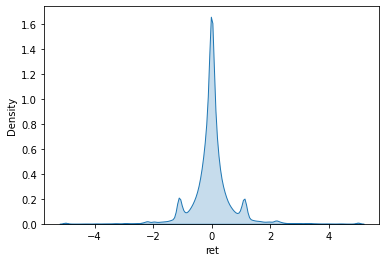

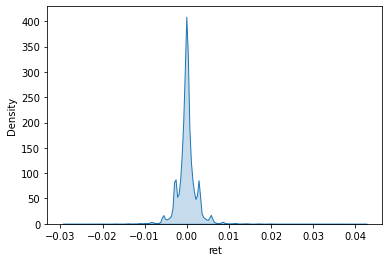

norm data done 

MA5       3.922962
STD5      3.921372
MIN5      3.905188
MAX5      3.904837
STD10     3.803199
            ...   
BETA5     0.148681
vma10     0.147279
vstd10    0.146344
vma5      0.111079
vstd5     0.108750
Name: MI Scores, Length: 90, dtype: float64
count    90.000000
mean      1.958716
std       1.338708
min       0.108750
25%       0.472085
50%       1.810614
75%       3.350623
max       3.922962
Name: MI Scores, dtype: float64
all works done 



In [4]:
# 数据重采样、标准化、因子正交化、特征选择、数据清洗等

x_train, x_test, y_train, y_test, ymean, ystd = scutquant.auto_process(data_preprocess, 'ret')

[0]	validation_0-rmse:1.05629
[1]	validation_0-rmse:1.04609
[2]	validation_0-rmse:1.03676
[3]	validation_0-rmse:1.02817
[4]	validation_0-rmse:1.02032
[5]	validation_0-rmse:1.01299
[6]	validation_0-rmse:1.00614
[7]	validation_0-rmse:0.99979
[8]	validation_0-rmse:0.99448
[9]	validation_0-rmse:0.98934
[10]	validation_0-rmse:0.98444
[11]	validation_0-rmse:0.97980
[12]	validation_0-rmse:0.97512
[13]	validation_0-rmse:0.97131
[14]	validation_0-rmse:0.96771
[15]	validation_0-rmse:0.96458
[16]	validation_0-rmse:0.96151
[17]	validation_0-rmse:0.95866
[18]	validation_0-rmse:0.95635
[19]	validation_0-rmse:0.95383
[20]	validation_0-rmse:0.95174
[21]	validation_0-rmse:0.94987
[22]	validation_0-rmse:0.94797
[23]	validation_0-rmse:0.94652
[24]	validation_0-rmse:0.94498
[25]	validation_0-rmse:0.94318
[26]	validation_0-rmse:0.94195
[27]	validation_0-rmse:0.94069
[28]	validation_0-rmse:0.93961
[29]	validation_0-rmse:0.93873
[30]	validation_0-rmse:0.93787
[31]	validation_0-rmse:0.93673
[32]	validation_0-

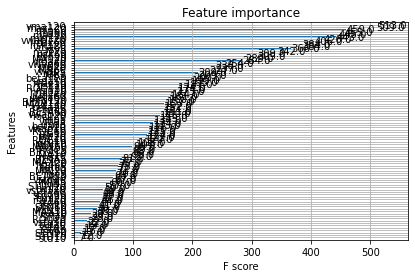

BETA5    0.030365
rsv20    0.027214
MIN60    0.022163
MAX20    0.021020
rsv60    0.018630
           ...   
roc10    0.004136
vstd5    0.003961
roc5     0.003484
vma5     0.003354
beta5    0.002401
Length: 90, dtype: float32 

Linear Model Coef:
MAX20     4.519850
MAX120    3.250199
MAX5      2.840297
MAX10     2.403333
STD5      1.545024
            ...   
MA60     -1.897325
STD60    -1.897325
MIN20    -3.588626
MA120    -4.830831
STD120   -4.830831
Length: 90, dtype: float64


In [5]:
# 训练模型，包括配置参数、训练和解释模型

xgb_params = {
    'est': 800,
    'eta': 0.0421,
    'colsamp': 0.8875,
    'subsamp': 0.8725,
    'max_depth': 10,
    'l1': 45,
    'l2': 50,
    'early_stopping_rounds': 20
}
model = scutquant.hybrid(lrg_method='ridge', xgb_params=xgb_params, weight=[0.1, 0.9])
model.fit(x_train, y_train, x_test, (y_test-ymean)/ystd)
model.explain_model(index=x_test.columns)

In [6]:
# 得到预测值

pred_train = model.predict(x_train)
pred_train = pd.DataFrame({'predict': pred_train}, index=x_train.index)
pred_train += ymean
pred_train *= ystd

pred_test = model.predict(x_test)
pred_test = pd.DataFrame({'predict': pred_test}, index=x_test.index)
pred_test += ymean
pred_test *= ystd

pred = pd.concat([pred_train, pred_test], axis=0)

In [7]:
# 此处仅使用测试集数据进行IC分析

ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred_test, y_test, groupby='time', plot=False)
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

ic= 0.058964799953626884 icir= 0.08253804751346143 rank_ic= 0.047735838373361504 rank_icir= 0.07055882065953666


In [8]:
# 将数据整理成executor要求的样子（索引为多重索引[('time', 'code')], 数据的列名包括 'predict'、'time' 和 'price'）

df1 = df[df.index.isin(pred.index)]
df1 = df1.reset_index()
df1['t'] = df1['time']
df1 = df1.set_index(['time', 'code']).sort_index()

pred['time'] = df1['t']
pred['price'] = df1['lastPrice']

In [9]:
#  todo: 自动生成price，在给定总资金量时自动生成position

acc = {
    'cash': 4000000,
    'position': {'601318.SH': 36100, '002303.SZ': 470200, '000049.SZ': 36100, '000333.SZ': 30400},
    'available': {'601318.SH': 36100, '002303.SZ': 470200, '000049.SZ': 36100, '000333.SZ': 30400},
    'price': {'601318.SH': 41.58, '002303.SZ': 3.19, '000049.SZ': 41.59, '000333.SZ': 49.31}
}

In [10]:
# 执行回测，输入参数分别为信号生成模式(generate/generate_series/simulate)，后两种目前还没实现；账户信息；买入和卖出费率；
# 最低交易费用和风险度

exe = executor.Executor(generator={'mode': 'generate'}, acc=acc, cost_buy=0.00015, cost_sell=0.00005, min_cost=5, risk_degree=0.95)
exe.execute(data=pred)

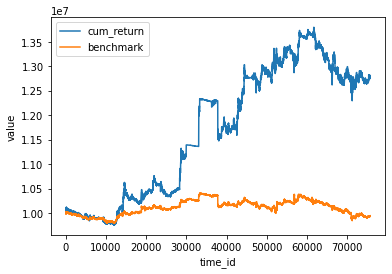

In [11]:
# 绘制资金曲线（目前可获取的数据有资金曲线、交易记录、风险度曲线、交易费用、持仓量和可用持仓量，这里只展示资金曲线和风险度曲线）

import matplotlib.pyplot as plt

user_account, benchmark = exe.user_account.val_hist, exe.benchmark.val_hist
acc_hist, ben_hist = pd.DataFrame({'value': user_account}), pd.DataFrame({'value': benchmark})

plt.plot(acc_hist, label='cum_return')
plt.plot(ben_hist, label='benchmark')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()

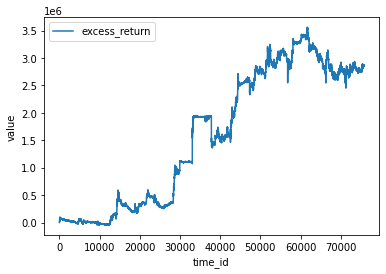

              value
75744  2.856771e+06


In [12]:
excess_return = acc_hist - ben_hist
plt.plot(excess_return, label='excess_return')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()
print(excess_return.iloc[-1:])

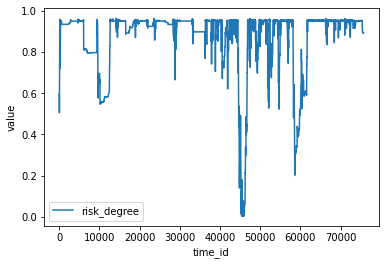

In [13]:
risk = pd.DataFrame({'risk': exe.user_account.risk_curve})

plt.plot(risk, label='risk_degree')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()

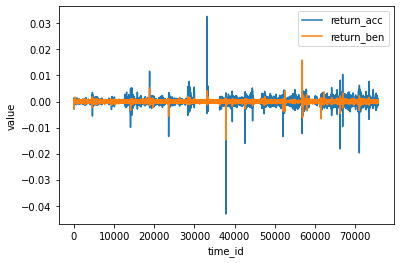

In [14]:
ret_acc, ret_ben = scutquant.price2ret(acc_hist['value'], 1, 0), scutquant.price2ret(ben_hist['value'], 1, 0)

plt.plot(ret_acc, label='return_acc')
plt.plot(ret_ben, label='return_ben')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()